In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patchworklib as pw
import seaborn as sns
import xarray as xr
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding

plt.style.use("papers")
pw.overwrite_axisgrid()

FOLDER = "../../results/20220331_random_data_stuff_200subjects_20channels_4states/"

<Figure size 72x72 with 0 Axes>

In [2]:
data = pd.read_csv(
    os.path.join(FOLDER, "data_and_segmentation.csv"), index_col=[0, 1]
).rename(columns={"kmeans": "mod. K-Means"})
stats = pd.read_csv(os.path.join(FOLDER, "basic_stats.csv"), index_col=0)
dynstats = pd.read_csv(os.path.join(FOLDER, "dyn_stats.csv"), index_col=0)
maps = xr.open_dataarray(os.path.join(FOLDER, "topomaps.nc"))

In [3]:
COLUMNS_ORDER = [
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]
data_for_corr = data.iloc[:, 20:].loc[:, COLUMNS_ORDER]
data_for_corr = data_for_corr.groupby("subject").corr("spearman").unstack()

In [4]:
data.iloc[:, 20:].loc[:, COLUMNS_ORDER].groupby("subject").corr("spearman").unstack().mean()

AAHC          AAHC            1.000000
              TAAHC           0.083603
              mod. K-Means   -0.015300
              HMM            -0.001462
              PCA            -0.001497
              ICA            -0.001249
TAAHC         AAHC            0.083603
              TAAHC           1.000000
              mod. K-Means   -0.003928
              HMM             0.002793
              PCA             0.013212
              ICA             0.002854
mod. K-Means  AAHC           -0.015300
              TAAHC          -0.003928
              mod. K-Means    1.000000
              HMM            -0.008453
              PCA            -0.008279
              ICA            -0.009388
HMM           AAHC           -0.001462
              TAAHC           0.002793
              mod. K-Means   -0.008453
              HMM             1.000000
              PCA             0.000265
              ICA             0.004352
PCA           AAHC           -0.001497
              TAAHC      

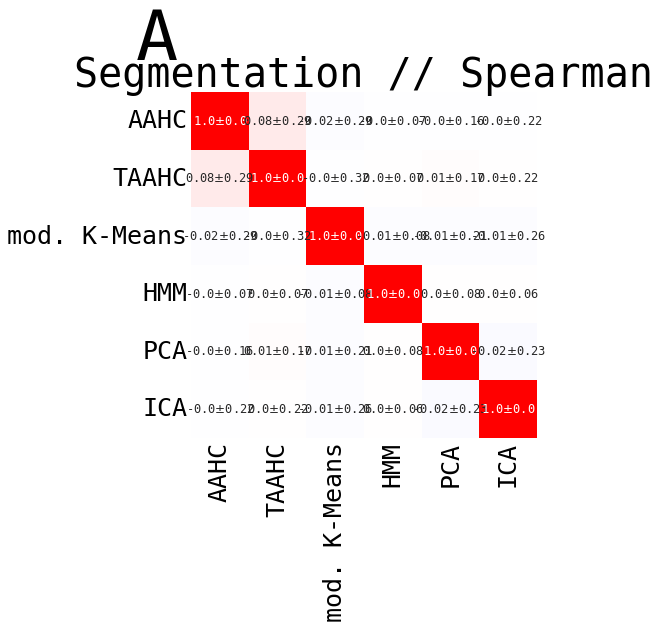

In [5]:
segm_mean = (
    data_for_corr.mean()
    .reset_index()
    .pivot(index="level_0", columns="level_1")
    .loc[COLUMNS_ORDER, (0, COLUMNS_ORDER)]
)
segm_mean.index.name = ""
segm_mean.columns = segm_mean.columns.get_level_values(1)
segm_mean.columns.name = ""

segm_std = (
    data_for_corr.std()
    .reset_index()
    .pivot(index="level_0", columns="level_1")
    .loc[COLUMNS_ORDER, (0, COLUMNS_ORDER)]
)
segm_std.index.name = ""
segm_std.columns = segm_std.columns.get_level_values(1)
segm_std.columns.name = ""

g1 = pw.Brick("ax0", figsize=(6, 6))
sns.heatmap(
    segm_mean,
    square=True,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=segm_mean.round(2).astype(str) + "$\pm$" + segm_std.round(2).astype(str),
    fmt="",
    ax=g1,
)
g1.set_title("Segmentation // Spearman")
g1.text(
    -0.1,
    1.15,
    "A",
    ha="center",
    va="center",
    transform=g1.transAxes,
    fontsize=70,
)
g1.savefig(quick=True)
# mean = prep.
# std = prep.std(ddof=1).reset_index().pivot(index="level_0", columns="level_1")

In [6]:
# rcorrs = data[data.columns[3:]].corr("spearman")
# np.fill_diagonal(rcorrs.values, np.nan)
# g7 = pw.Brick("ax54", figsize=(3, 3))
# sns.heatmap(
#     rcorrs,
#     square=True,
#     vmax=1.0,
#     vmin=-1,
#     cmap="bwr",
#     annot=data[data.columns[3:]].rcorr("spearman", padjust="fdr_by", decimals=2),
#     fmt="",
#     annot_kws={"fontsize": 14},
#     ax=g7,
# )
# g7.set_title("Segmentation // Spearman")
# # g7 = pw.load_seaborngrid(g)
# display(data[data.columns[3:]].rcorr("spearman", padjust="fdr_by"))

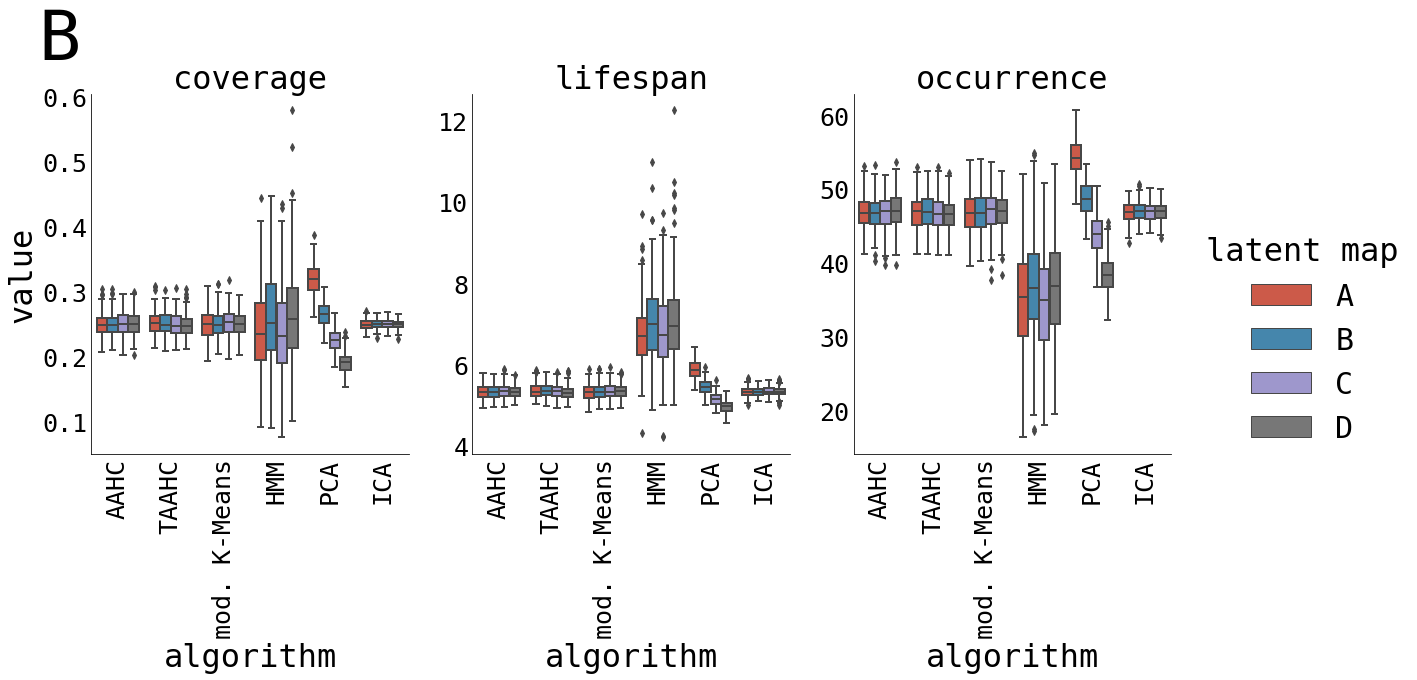

In [6]:
stats = (
    stats.replace({"kmeans": "mod. K-Means"})
    .rename(columns={"var_GFP": "var GFP", "var_total": "var total"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
)
stats_melt = stats.melt(
    id_vars=["algorithm", "latent map"],
    value_vars=["coverage", "lifespan", "occurrence"],
)
g = sns.catplot(
    data=stats_melt,
    x="algorithm",
    y="value",
    hue="latent map",
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0][0].text(
    -0.1,
    1.15,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g2 = pw.load_seaborngrid(g)
g2.savefig(quick=True)

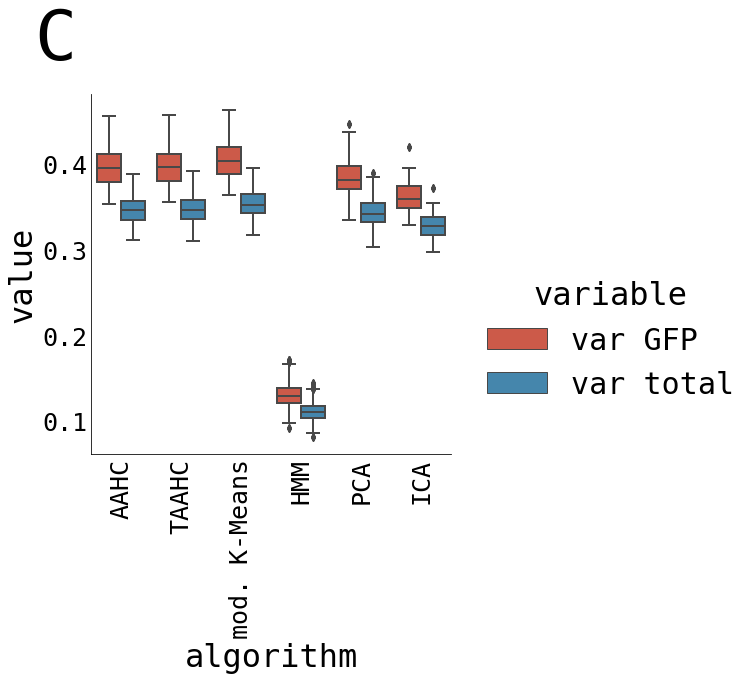

In [7]:
g = sns.catplot(
    data=stats.melt(id_vars="algorithm", value_vars=["var GFP", "var total"]),
    x="algorithm",
    y="value",
    hue="variable",
    kind="box",
)
g.axes[0][0].text(
    -0.1,
    1.15,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)

g3 = pw.load_seaborngrid(g)
g3.savefig(quick=True)

In [9]:
dynstats

,algorithm,subject,mixing time,entropy,max entropy,entropy rate,MC entropy rate,AIF 1st peak
0,PCA,rnd_subject_4,1.024593,1.382002,1.386294,1.244917,1.992197,68.0
1,ICA,rnd_subject_4,1.000046,1.386185,1.386294,1.247124,1.997588,40.0
2,kmeans,rnd_subject_4,1.007490,1.384587,1.386294,1.243186,1.993129,36.0
3,AAHC,rnd_subject_4,1.036421,1.385486,1.386294,1.243490,1.995976,52.0
4,TAAHC,rnd_subject_4,0.990172,1.384778,1.386294,1.237117,1.994515,44.0
...,...,...,...,...,...,...,...,...
1,ICA,rnd_subject_199,0.994465,1.385618,1.386294,1.238401,1.997544,52.0
2,kmeans,rnd_subject_199,1.005161,1.385790,1.386294,1.243437,1.997442,48.0
3,AAHC,rnd_subject_199,1.018589,1.383973,1.386294,1.244452,1.995503,56.0
4,TAAHC,rnd_subject_199,1.027475,1.384960,1.386294,1.237696,1.996579,40.0


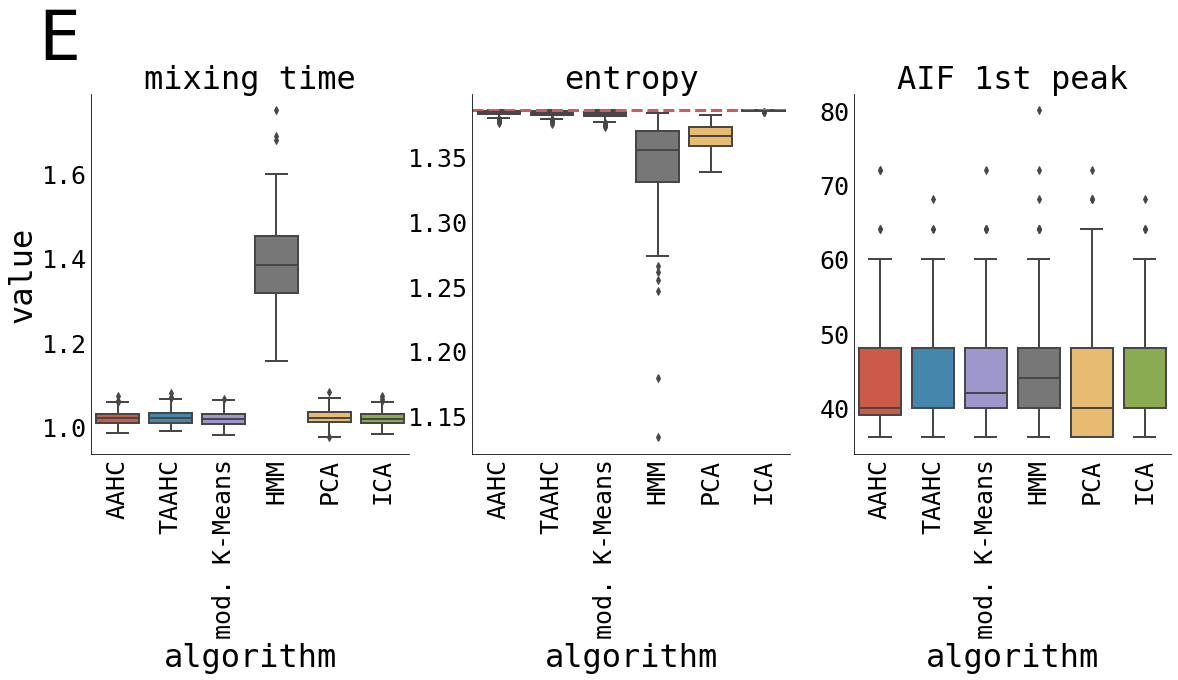

In [8]:
dynstats_melt = (
    dynstats.replace({"kmeans": "mod. K-Means"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["mixing time", "entropy", "AIF 1st peak"],
    )
)
g = sns.catplot(
    data=dynstats_melt,
    x="algorithm",
    y="value",
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0, 1].axhline(
    dynstats["max entropy"].unique()[0],
    linestyle="--",
    color="indianred",
    linewidth=3.0,
)
g.axes[0][0].text(
    -0.1,
    1.15,
    "E",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g4 = pw.load_seaborngrid(g)
g4.savefig(quick=True)

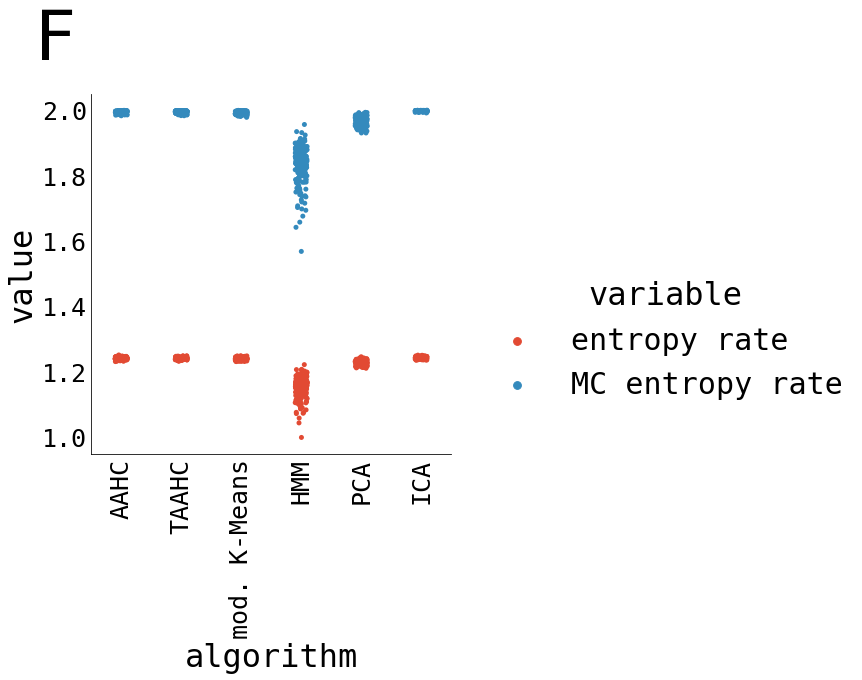

In [9]:
g = sns.catplot(
    data=dynstats.replace({"kmeans": "mod. K-Means"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["entropy rate", "MC entropy rate"],
    ),
    x="algorithm",
    y="value",
    hue="variable",
)
g.axes[0][0].text(
    -0.1,
    1.15,
    "F",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)

g5 = pw.load_seaborngrid(g)
g5.savefig(quick=True)

In [10]:
all_corrs = []
for alg1 in maps["algorithm"]:
    for alg2 in maps["algorithm"]:
        for map1 in maps["latent map"]:
            for map2 in maps["latent map"]:
                corrs = (
                    xr.corr(
                        maps.sel({"algorithm": alg1, "latent map": map1}),
                        maps.sel({"algorithm": alg2, "latent map": map2}),
                        dim="channels",
                    )
                    .assign_coords(
                        {"alg1": alg1, "alg2": alg2, "map1": map1, "map2": map2}
                    )
                    .expand_dims(["alg1", "alg2", "map1", "map2"])
                )
                all_corrs.append(corrs)
all_corrs = np.abs(xr.combine_by_coords(all_corrs))

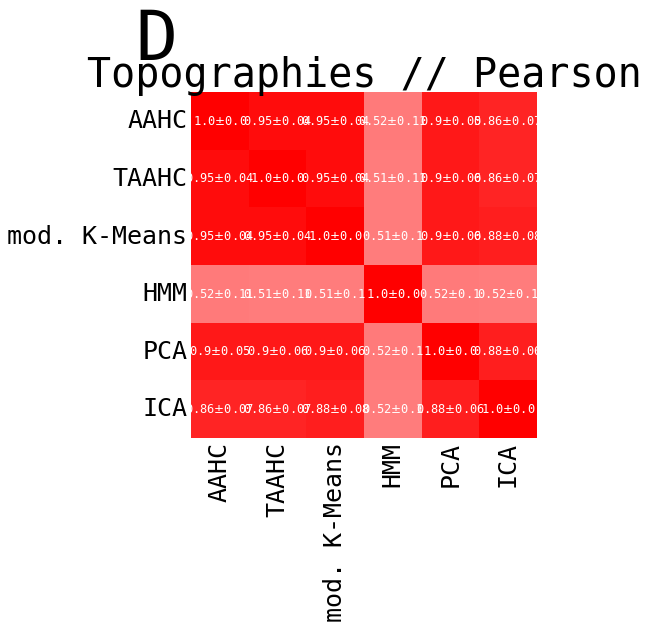

In [11]:
mean = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .mean("subject")
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
mean.index.name = ""
mean.columns = mean.columns.get_level_values(1)
mean.columns.name = ""
mean = mean.rename(
    columns={"kmeans": "mod. K-Means"}, index={"kmeans": "mod. K-Means"}
).loc[COLUMNS_ORDER, COLUMNS_ORDER]

std = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .std("subject", ddof=1)
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
std.index.name = ""
std.columns = std.columns.get_level_values(1)
std.columns.name = ""
std = std.rename(
    columns={"kmeans": "mod. K-Means"}, index={"kmeans": "mod. K-Means"}
).loc[COLUMNS_ORDER, COLUMNS_ORDER]

g6 = pw.Brick("ax6", figsize=(6, 6))
sns.heatmap(
    mean,
    square=True,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=mean.round(2).astype(str) + "$\pm$" + std.round(2).astype(str),
    fmt="",
    ax=g6,
)
g6.set_title("Topographies // Pearson")
g6.text(
    -0.1,
    1.15,
    "D",
    ha="center",
    va="center",
    transform=g6.transAxes,
    fontsize=70,
)
g6.savefig(quick=True)

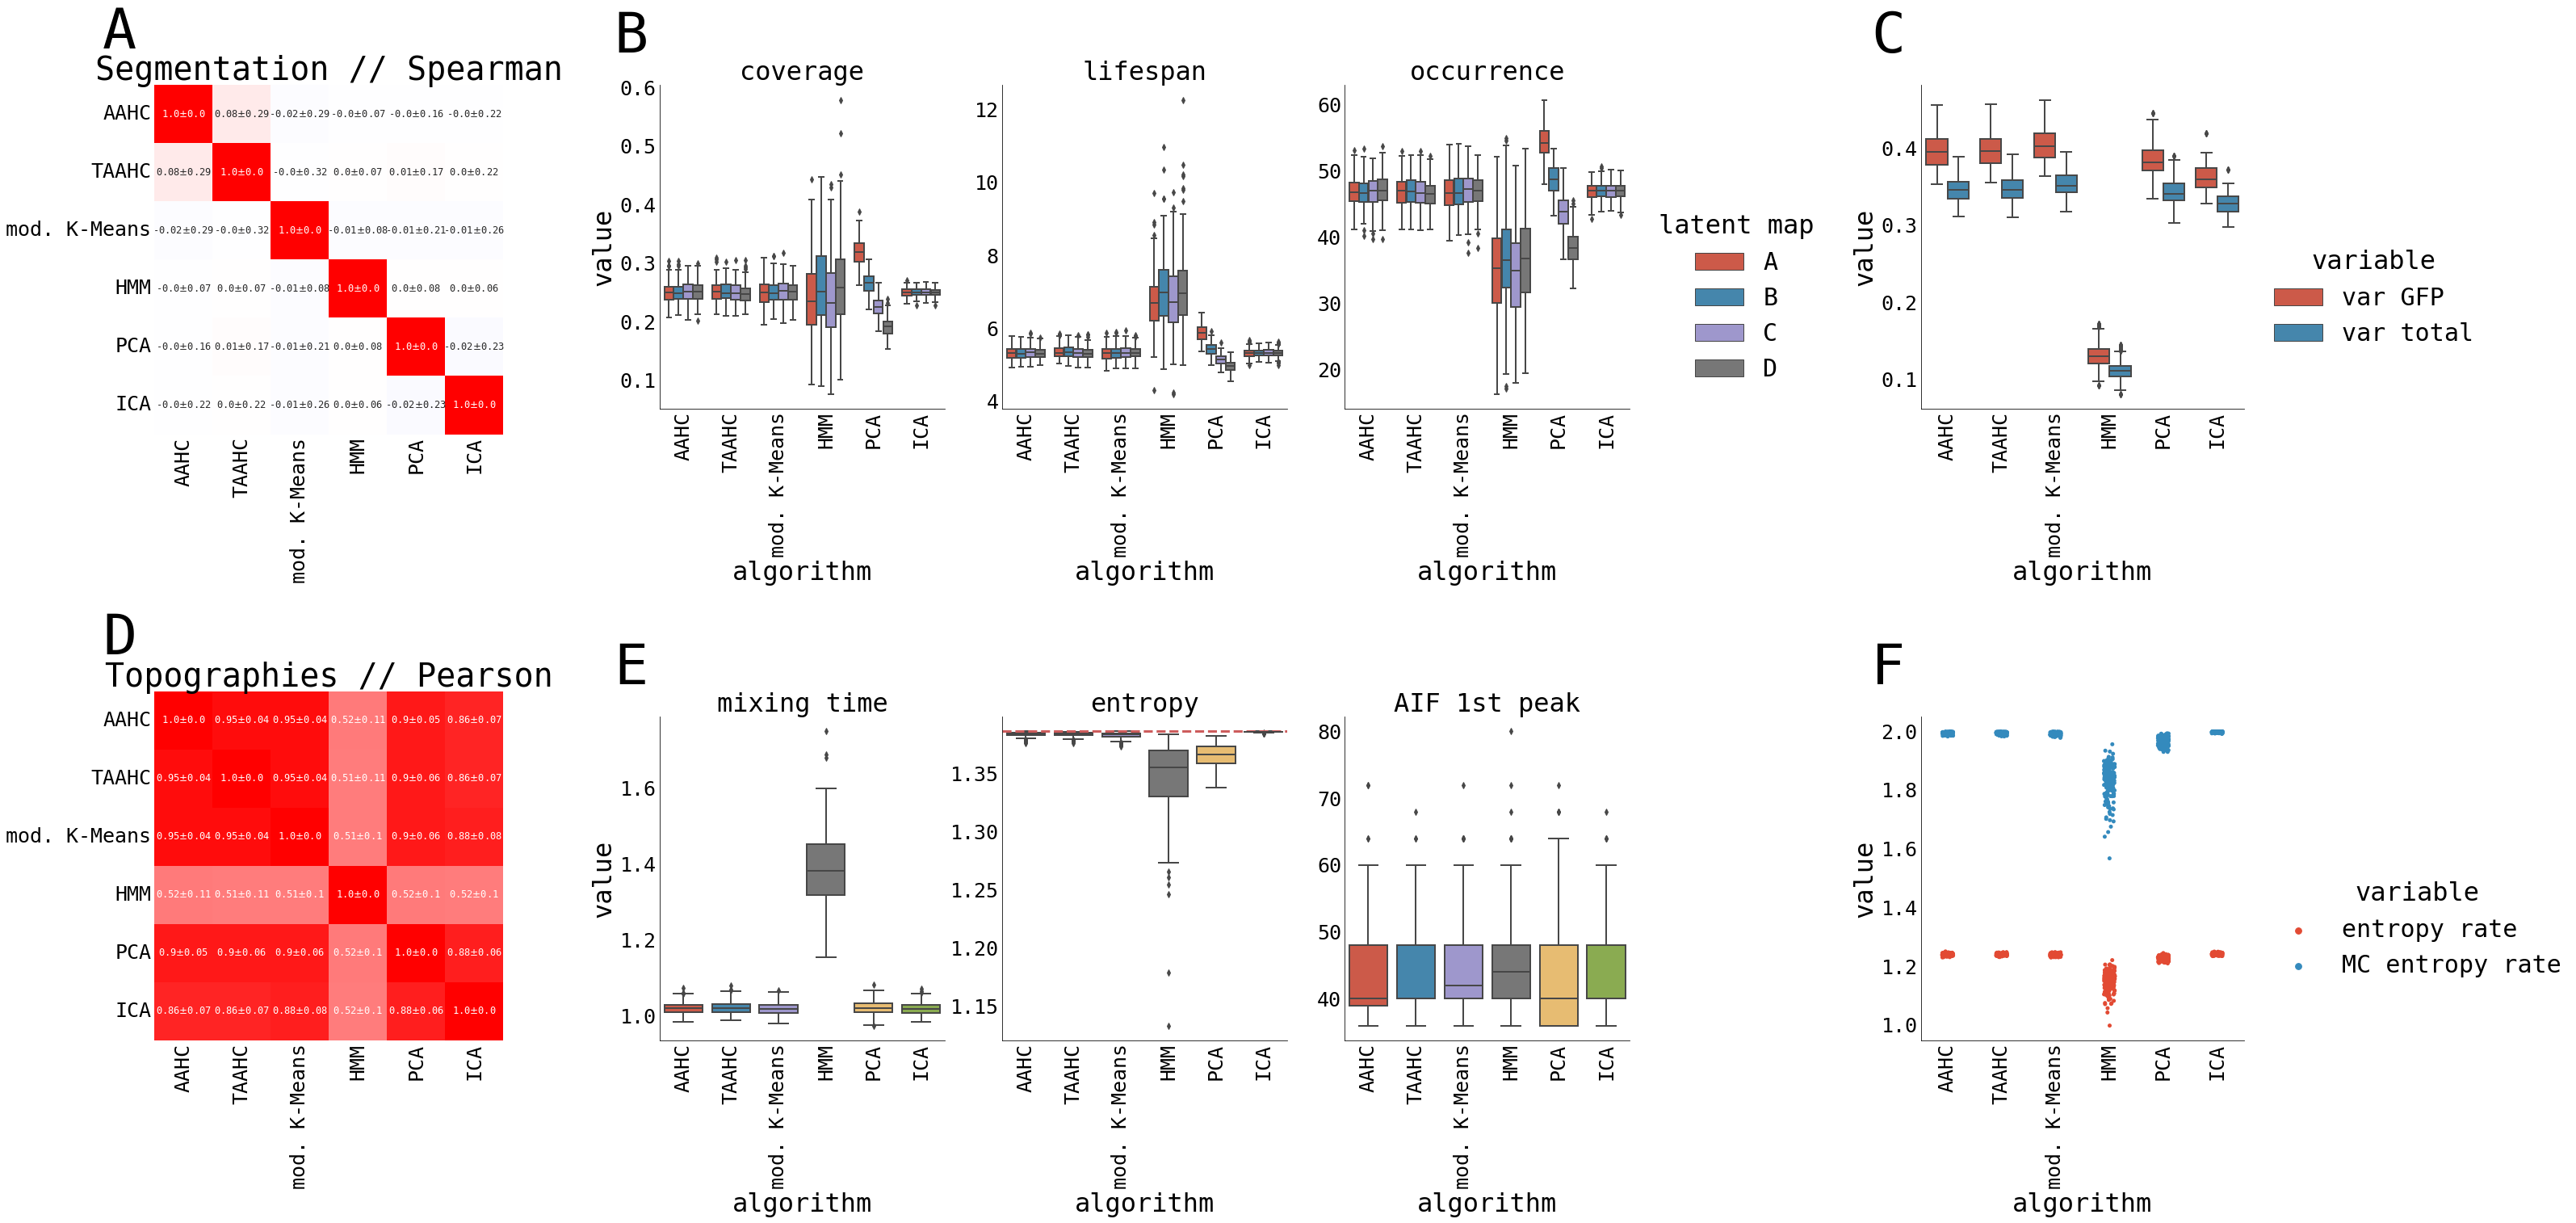

In [12]:
((g1 / g6) | (g2 / g4) | (g3 / g5)).savefig(
    fname="synthetic_subjectwise_stats.pdf", transparent=True
)

In [13]:
mean = (
    all_corrs.where(all_corrs.alg1 == all_corrs.alg2, drop=True)
    .where(all_corrs.map1 != all_corrs.map2)
    .max(["map1", "map2"])
    .mean("subject")
    .to_series()
    .dropna()
    .reset_index()
    .drop("alg2", axis=1)
    .rename(columns={"alg1": "algorithm", 0: "rho"})
    .set_index("algorithm")
)
std = (
    all_corrs.where(all_corrs.alg1 == all_corrs.alg2, drop=True)
    .where(all_corrs.map1 != all_corrs.map2)
    .max(["map1", "map2"])
    .std("subject", ddof=1)
    .to_series()
    .dropna()
    .reset_index()
    .drop("alg2", axis=1)
    .rename(columns={"alg1": "algorithm", 0: "rho"})
    .set_index("algorithm")
)
mean.round(3).astype(str) + " $\pm$ " + std.round(3).astype(str)

,rho
algorithm,
AAHC,0.507 $\pm$ 0.096
HMM,0.559 $\pm$ 0.078
ICA,0.185 $\pm$ 0.06
PCA,0.063 $\pm$ 0.045
TAAHC,0.491 $\pm$ 0.095
kmeans,0.425 $\pm$ 0.098


In [14]:
COLUMNS_ORDER

['AAHC', 'TAAHC', 'mod. K-Means', 'HMM', 'PCA', 'ICA']

In [20]:
def get_pca(decomp):
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(
        maps.stack(samples=("subject", "latent map"))
        .sel({"algorithm": decomp})
        .values.T
    )
    low_dim = pd.DataFrame(pcs, columns=["PC 0", "PC 1"])
    low_dim["map"] = maps.stack(samples=("subject", "latent map")).sel(
        {"algorithm": decomp}
    )["latent map"]
    g = sns.jointplot(data=low_dim, x="PC 0", y="PC 1", hue="map")
    g.ax_joint.legend_._visible = False
    g.ax_marg_x.set_title(decomp)
    return g


def get_tsne(decomp):
    tsne = TSNE(n_components=2, init="pca", n_jobs=6)
    pcs = tsne.fit_transform(
        maps.stack(samples=("subject", "latent map"))
        .sel({"algorithm": decomp})
        .values.T
    )
    low_dim = pd.DataFrame(pcs, columns=["t-SNE 0", "t-SNE 1"])
    low_dim["map"] = maps.stack(samples=("subject", "latent map")).sel(
        {"algorithm": decomp}
    )["latent map"]
    g = sns.jointplot(data=low_dim, x="t-SNE 0", y="t-SNE 1", hue="map")
    g.ax_joint.legend_._visible = False
    return g


def get_mds(decomp):
    mds = MDS(n_components=2, n_jobs=6)
    pcs = mds.fit_transform(
        maps.stack(samples=("subject", "latent map"))
        .sel({"algorithm": decomp})
        .values.T
    )
    low_dim = pd.DataFrame(pcs, columns=["MDS 0", "MDS 1"])
    low_dim["map"] = maps.stack(samples=("subject", "latent map")).sel(
        {"algorithm": decomp}
    )["latent map"]
    g = sns.jointplot(data=low_dim, x="MDS 0", y="MDS 1", hue="map")
    g.ax_joint.legend_._visible = False
    return g


def get_lle(decomp):
    lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, n_jobs=6)
    pcs = lle.fit_transform(
        maps.stack(samples=("subject", "latent map"))
        .sel({"algorithm": decomp})
        .values.T
    )
    low_dim = pd.DataFrame(pcs, columns=["LLE 0", "LLE 1"])
    low_dim["map"] = maps.stack(samples=("subject", "latent map")).sel(
        {"algorithm": decomp}
    )["latent map"]
    g = sns.jointplot(data=low_dim, x="LLE 0", y="LLE 1", hue="map")
    g.ax_joint.legend_._visible = False
    return g


maps["algorithm"] = ["AAHC", "HMM", "ICA", "PCA", "TAAHC", "mod. K-Means"]

g = get_pca("AAHC")
g.ax_marg_x.text(
    0.0,
    0.9,
    "G",
    ha="center",
    va="center",
    transform=g.ax_marg_x.transAxes,
    fontsize=90,
)
g10 = pw.load_seaborngrid(g)
g11 = pw.load_seaborngrid(get_pca("TAAHC"))
g12 = pw.load_seaborngrid(get_pca("mod. K-Means"))
g13 = pw.load_seaborngrid(get_pca("HMM"))
g14 = pw.load_seaborngrid(get_pca("PCA"))
g15 = pw.load_seaborngrid(get_pca("ICA"))

g20 = pw.load_seaborngrid(get_tsne("AAHC"))
g21 = pw.load_seaborngrid(get_tsne("TAAHC"))
g22 = pw.load_seaborngrid(get_tsne("mod. K-Means"))
g23 = pw.load_seaborngrid(get_tsne("HMM"))
g24 = pw.load_seaborngrid(get_tsne("PCA"))
g25 = pw.load_seaborngrid(get_tsne("ICA"))

g30 = pw.load_seaborngrid(get_mds("AAHC"))
g31 = pw.load_seaborngrid(get_mds("TAAHC"))
g32 = pw.load_seaborngrid(get_mds("mod. K-Means"))
g33 = pw.load_seaborngrid(get_mds("HMM"))
g34 = pw.load_seaborngrid(get_mds("PCA"))
g35 = pw.load_seaborngrid(get_mds("ICA"))

g40 = pw.load_seaborngrid(get_lle("AAHC"))
g41 = pw.load_seaborngrid(get_lle("TAAHC"))
g42 = pw.load_seaborngrid(get_lle("mod. K-Means"))
g43 = pw.load_seaborngrid(get_lle("HMM"))
g44 = pw.load_seaborngrid(get_lle("PCA"))
g45 = pw.load_seaborngrid(get_lle("ICA"))

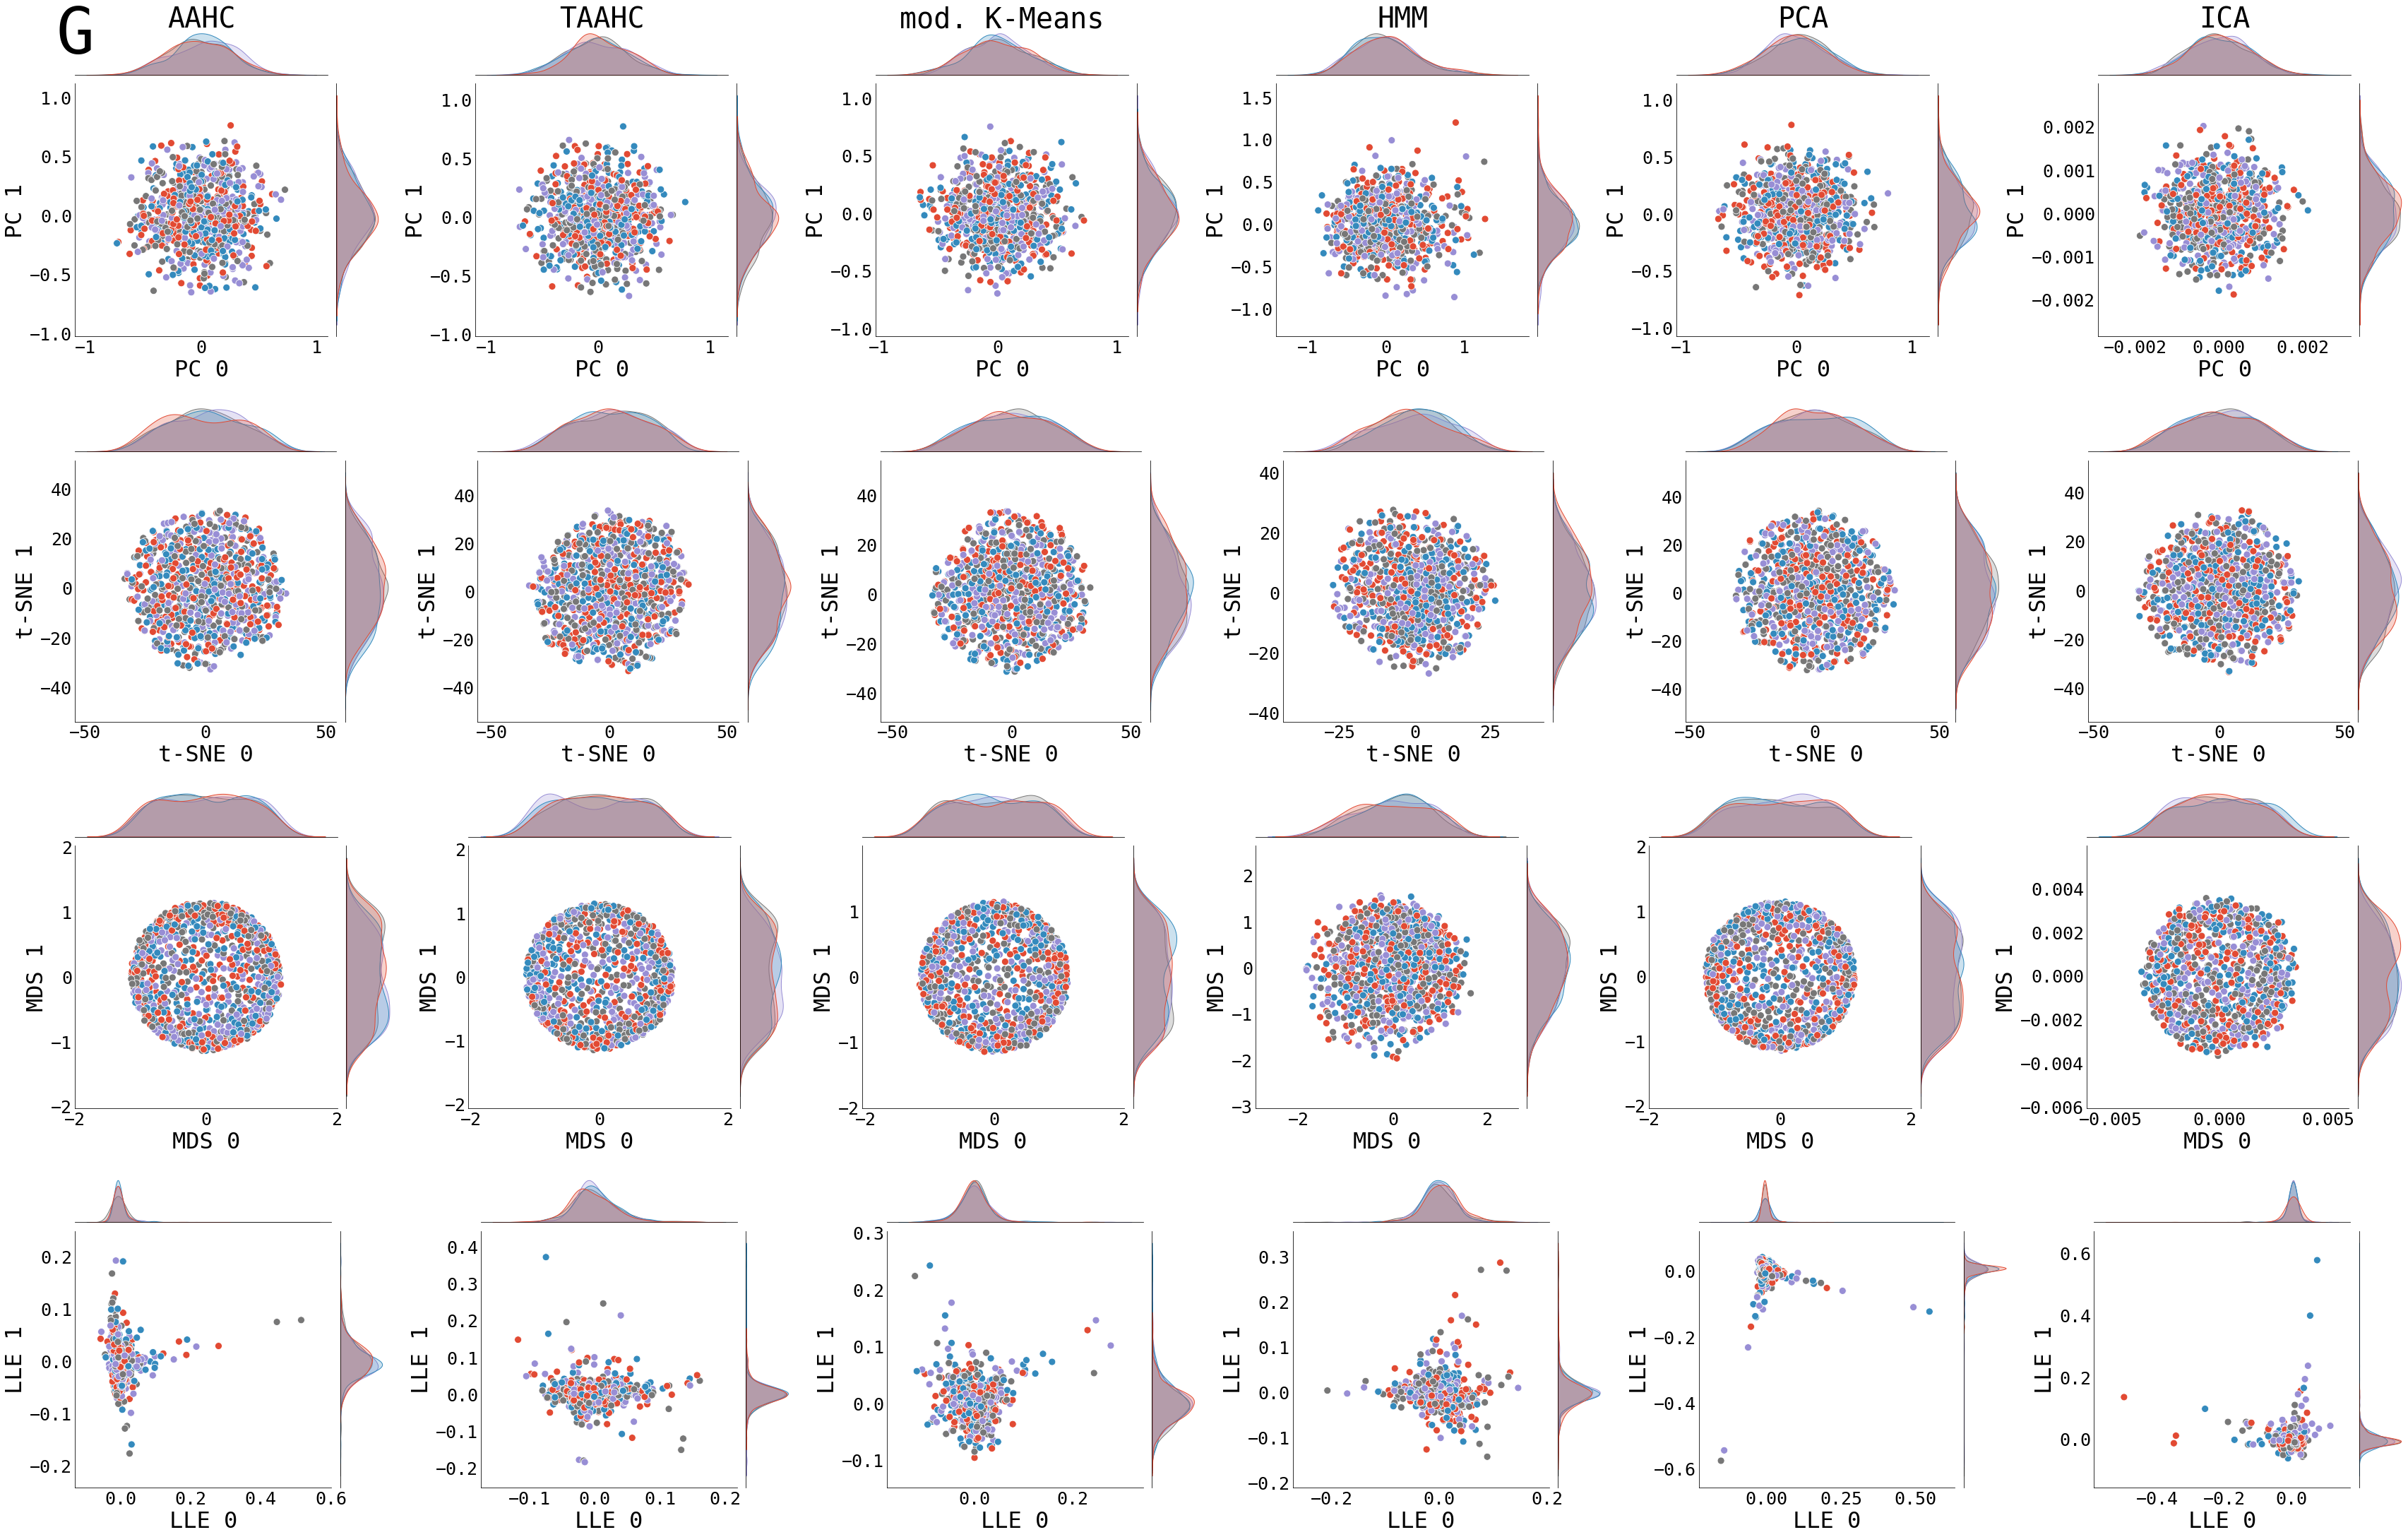

In [21]:
(
    (g10 | g11 | g12 | g13 | g14 | g15)
    / (g20 | g21 | g22 | g23 | g24 | g25)
    / (g30 | g31 | g32 | g33 | g34 | g35)
    / (g40 | g41 | g42 | g43 | g44 | g45)
).savefig(fname="synthetic_subjectwise_lowdim_repr.pdf", transparent=True)